#Machine Learning Estadístico para Interfaces Cerebro-Computadora

## Trabajo Práctico de Laboratorio de Computación II - Parte I: Introducción al filtrado espacial y rereferenciado

Este TPLC tiene como objetivo que el alumno sea capaz de:
1. Afianzar los conocimientos sobre filtrado espacial como métodos de rereferenciado aprendidos en la instancia teórica.
2. Implementar algoritmos básicos basados en transformaciones lineales para reducción de la dimensionalidad.
3. Comprender la diferencia entre filtros y patrones espaciales.


Es **requisito** para aprobar este curso que esta guía práctica sea completada y enviada para su evaluación. Se aceptan trabajos realizados en forma grupal de *hasta dos alumnos por grupo*.


❗Antes de comenzar recordá hacer una copia de este documento de manera que puedas editarlo y guardar los cambios en tu Drive.

In [1]:
# importamos las bibliotecas y funciones
import numpy as np
import matplotlib.pyplot as plt
from mne.channels import make_standard_montage
from mne.io import concatenate_raws, read_raw_edf
from mne import Epochs, pick_types, events_from_annotations
import mne

# Los datos

Vamos a utilizar la base de datos de imaginería motora de EEGBCI que utilizamos antes, la cual fue originalmente publicada en [2] y consiste en varios experimentos de BCI realizados a la misma persona. En particular vamos utilizar los datos del sujeto 1 durante las rondas correspondientes a la imaginación del movimiento de mano derecha e izquierda

In [2]:
# load the data
from mne.datasets import eegbci

subject = 1  # one subject
runs = [4, 8, 12]  # motor imagery: left vs right hand runs
event_id = dict(right=1, left=2)

raw_fnames = eegbci.load_data(subject, runs)
raw = concatenate_raws([read_raw_edf(f, preload=True) for f in raw_fnames])
eegbci.standardize(raw)  # set channel names
montage = make_standard_montage("standard_1005")
raw.set_montage(montage)


Extracting EDF parameters from C:\Users\felip\mne_data\MNE-eegbci-data\files\eegmmidb\1.0.0\S001\S001R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from C:\Users\felip\mne_data\MNE-eegbci-data\files\eegmmidb\1.0.0\S001\S001R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from C:\Users\felip\mne_data\MNE-eegbci-data\files\eegmmidb\1.0.0\S001\S001R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...


<RawEDF | S001R04.edf, 64 x 60000 (375.0 s), ~29.4 MB, data loaded>

Como vimos en la guía pasada, al estar trabajando con datos de imaginería motora, esperaríamos observar en el dominio espectral picos alredor de la onda alpha (8-12 Hz) y beta (12-30 Hz). Asimismo, en el dominio espacial, esperaríamos ver que la energía cambia en las cercanís del canal C3 y C4 para MI de mano derecha e izquierda, respectivamente.

Como antes, para evitar el P300 asociado al visual cue, y obtener una ventana de análisis que permita estudiar el MI, vamos a segmentar nuestros datos en épocas de 2 seg de duranción desde los 0.5 seg luego del cue onset.

In [3]:
# get channel names
ch_names = raw.ch_names

In [4]:
# before epoching, apply a filter!
# Apply band-pass filter
raw.filter(1.0, 40.0, fir_design="firwin", skip_by_annotation="edge")
# select the epoch time
tmin, tmax = 0.5, 2.5
events, _ = events_from_annotations(raw, event_id=dict(T1=1, T2=2))

picks = pick_types(raw.info, meg=False, eeg=True, stim=False, eog=False, exclude="bads")

# Epoch the band-pass filtered data
epochs = Epochs(
    raw,
    events,
    event_id,
    tmin,
    tmax,
    proj=True,
    picks=picks,
    baseline=None,
    preload=True,
)

Filtering raw data in 3 contiguous segments
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 529 samples (3.306 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.2s finished


Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
45 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 45 events and 321 original time points ...
0 bad epochs dropped


Vamos a computar y graficar la densidad de potencia especial (PSD) de los datos epoqueados. Para eso, vamos a utilizar una función propia (gracias Catalina Galván por tú aporte). Solo vamos a enfocar nuestro análisis en los canales C3, C4, Cz.

In [5]:
# Define a custom function to plot PSDs.
def plot_PSD(PSD, channels_list, colors_list, title, axes, ylim):
  """
    author: Catalina Galván
    Plot Power Spectral Density (PSD) for multiple channels.

    Parameters:
        PSD (mne.time_frequency.psd.PSD): The Power Spectral Density object containing PSD data.
        channels_list (list): List of channel names or indices to plot.
        colors_list (list): List of colors for each channel's plot.
        title (str): The title of the plot.
        axes (matplotlib.axes.Axes): The matplotlib axes object to plot on.
        ylim (tuple): The y-axis limits as a tuple (min, max).

    Returns:
        None

    This function plots the Power Spectral Density (PSD) for multiple channels on a given set of axes.
    Each channel's PSD is represented by a line plot with a specified color and label.
    The function also adds a legend, gridlines, ylabel, title, and sets y-axis limits.
  """
  PSD_array, freqs = PSD.get_data(picks=channels_list, return_freqs=True)
  for c, channel in enumerate(channels_list):
    axes.plot(freqs, 10*np.log10(np.mean(10e12*PSD_array[:, c], axis=0)),
              color=colors_list[c], label=channel,
              linewidth=1.2)
  axes.legend()
  axes.grid(True, linestyle=":")
  axes.set_ylabel("μV²/Hz");
  axes.set_title(title)
  axes.set_ylim(ylim)


In [6]:
channels_list = ['C3', 'C4', 'Cz']  # Channels of interest
colors_list = ['red', 'blue', 'green']  # List of colors for each channel

In [7]:
right_spectrum = epochs["right"].compute_psd()
left_spectrum = epochs["left"].compute_psd()

    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows


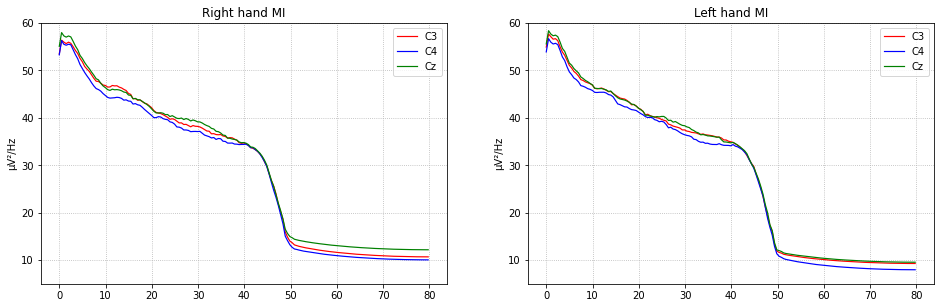

In [8]:
fig, axs = plt.subplots(1, 2, figsize=[16, 4.8])
plot_PSD(right_spectrum, channels_list, colors_list,
         title='Right hand MI', axes=axs[0], ylim=(5, 60))
plot_PSD(left_spectrum, channels_list, colors_list,
         title='Left hand MI', axes=axs[1], ylim=(5, 60))

# Filtrado Espacial para rereferenciado

## Métrodos tradicionales

Los métodos tradicionales de rereferenciado pueden pensarse como métodos de filtrado espacial dado una matriz de transformación fija y pre-definida.
En esta sección queremos que explores el impacto del filtrado bipolar, el filtrado CAR y el filtrado Small Laplacian. Nos vamos a enfocar aquí y en todo esta Colab en el efecto observado en los canales C3, C4 and Cz.

### Bipolar rereferencing

El rereferenciado bipolar es tan sencillo como restartle a cada canal el voltage de un cierto canal. Suele utilizarse un canal ubicado en la cabeza, que registre EEG. En ese sentido, estamos virtualmente cambiando la referencia original de los canales a uno situado en la cabeza.

#### Manos a la obra 🤝

1. Creá un objeto `epochs_bip`, el cuál tenga los datos rereferenciados al canal Pz. Graficá el PSD de los canales C3, C4 y Cz antes y después del rereferenciado para las épocas izquierdad y derechas de manera separada.
2. Repetí el ítem anterior pero ahora rereferenciando a Oz, y responde: ¿qué referencia mejora la energía de la señal? Jutificá tu rta.

💡 TIPs

1. Explora el método set_eeg.referenia de la clase [Epochs](https://mne.tools/stable/generated/mne.Epochs.html#mne.Epochs) de MNE


Rereferece to Pz

In [9]:
#escrbí tú código acá

Rereferece to Oz

In [10]:
#escrbí tú código acá

### CAR rereferencing

CAR (Common Average Reference), calcula el promedio de la contribución de todos los canales y lo subtrae de cada canal, creando canales rereferenciados a una referencia común a todos, dada por el valor promedio.

#### Manos a la obra 🤝

1. Creá un objeto `epochs_CAR`, el cuál tenga los datos rereferenciados mediante CAR. Graficá el PSD de los canales C3, C4 y Cz antes y después del rereferenciado para las épocas izquierdad y derechas de manera separada.
2. ¿Qué observas en comparación con el filtrado bipolar que hicimos antes?

💡 TIPs

1. Explora el método set_eeg.referenia de la clase [Epochs](https://mne.tools/stable/generated/mne.Epochs.html#mne.Epochs) de MNE


In [11]:
#escribí acá tú código

### Small Laplacian rereferencing

El filtrado Laplaciano pequeño (Small Laplacian) utiliza la contribución promedio de los 4 electrodos más cercanos al canal de interés. MNE no cuenta con una función para implementar este método. Pero no pasa nada, lo implementemos 😉

#### Manos a la obra 🤝

1. Inspeccioná el montaje de EEG cap y definí los electrodos que deberían seleccionarse para filtrar con small Laplacian al electrodos C3, C4 y Cz.
2. Implementá un código que filtre cada canal de EEG según sea su conjunto de vecinos más cercano. Llamá a la señal filtrada, resultado de este proceso `epochs_lap4`.
3. Graficá el PSD de los canales C3, C4 y Cz antes y después del rereferenciado para las épocas izquierdad y derechas de manera separada.
4. Responde: ¿Todos los electrodos se comportan igual ante el rereferenciado Small Laplacian? ¿ Hay algún o algunos que se benefician más?

💡 TIPs

1. Podes trabajar con la matriz de datos utilizando `get_data() `del objeto `epochs`
2. Podes volver a definir un objeto del tipo Epochs [Epochs](https://mne.tools/stable/generated/mne.Epochs.html#mne.Epochs) a partir del arreglo de datos filtrado utilizando la clase [EpochsArray](https://mne.tools/stable/generated/mne.EpochsArray.html)


By inspecting the channel cluters we see that for C3 the four closest channels are FC3, C5, C1 and CP3. Similarly, for Cz we have FCz, C1, C2 and CPz, while for C4 the Laplacian cluster is FC4, C6, C2 and CP4.

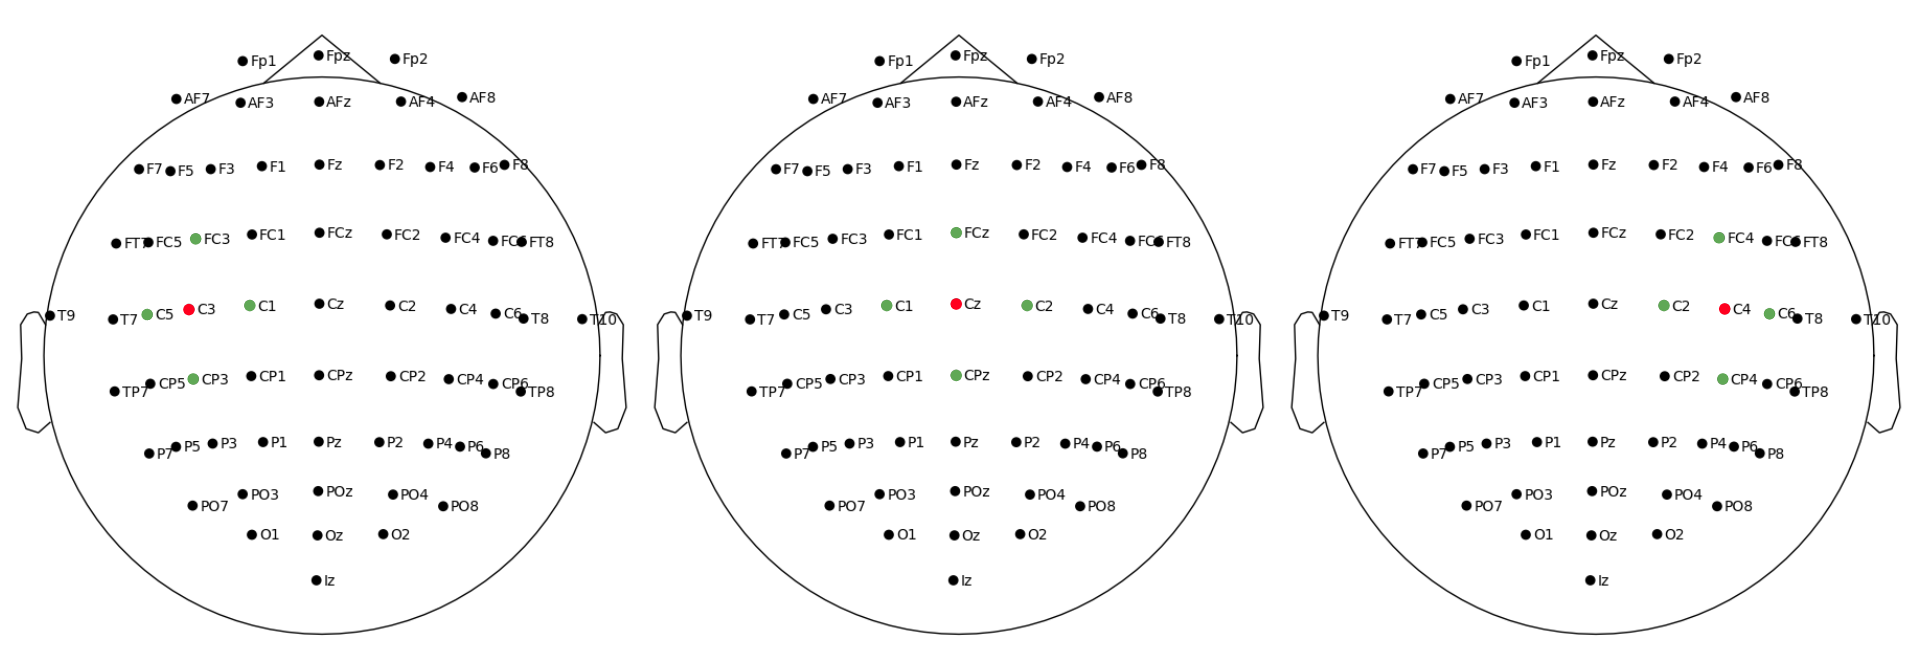

In [12]:
#completá el código
# Laplacian 4
# Define neighbours dictionary
lap4_dict = dict(C3 = [...],
                 Cz = [...],
                 C4 = [..])
# Get all epochs as a 3D array (Ntrials*Nchannels*Nsamples)
epochs_lap4_array = epochs.copy().get_data()
# Get measurement info (necessary to create an MNE Epochs object)
info = epochs.info

for _, channel in enumerate(['C3', 'C4', 'Cz']):
  channel_idx = info.ch_names.index(channel)
  # Calculate the mean value across the 4 neighbours for each time sample
  lap4_mean = ....
  # Substract the corresponding mean value for each time sample
  epochs_lap4_array[:, channel_idx, :] -= lap4_mean

# Create again an MNE Epochs object for rereferenced data
epochs_lap4 = mne.EpochsArray(epochs_lap4_array, info=info, events=events,
                              event_id=event_id)

SyntaxError: invalid syntax (983954916.py, line 6)

In [ ]:
right_spectrum_lap4 =...
left_spectrum_lap4 =....

fig, axs = plt.subplots(1, 2, figsize=[16, 4.8])
plot_PSD(right_spectrum, channels_list, colors_list,
         title='Right hand MI - Original', axes=axs[0], ylim=(0, 60))
plot_PSD(right_spectrum_lap4, channels_list, colors_list,
         title='Right hand MI - Laplacian 4', axes=axs[1], ylim=(0, 60))

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=[16, 4.8])
plot_PSD(left_spectrum, channels_list, colors_list,
         title='Left hand MI - Original', axes=axs[0], ylim=(0, 60))
plot_PSD(left_spectrum_lap4, channels_list, colors_list,
         title='Left hand MI - Laplacian 4', axes=axs[1], ylim=(0, 60))

## Spatio Spectra Decomposition (SSD)

El método de descomposición espacial espectral (SSD) propueso por Nikulin et al. [2] permite incrementar la relación-señal-ruido es una banda frecuencial de interés.

Aquí vamos a enfocaros en mejorar el contenido de la señal en la banda alpha (8 a 12 Hz). En consecuencia, todo lo que está "por fuera" de esta banda será considerado ruido.

Vamos a utilizar la implementación [SSD](https://mne.tools/dev/generated/mne.decoding.SSD.html) en MNE. La inspeccionamos un poco 👇

In [ ]:
# we import the MNE function
from mne.decoding import SSD
# inspect the function a little bit:
help(SSD)

#### Manos a la obra 🤝

1. Definí la banda de frecuencia de la señal (`freq_sig`) y del ruido (`freq_noise`) como tuplas.
2. Definí el objeto ssd y ajustá el modelo utilizando los datos. Utilzá los siguientes parámetros para ajustar el modelo:


```
n_components = None
sort_by_spectral_ratio = False
```




In [ ]:
# define the freq and noise band. Here we take a delta freq of 1 Hz
freqs_sig = ...
freqs_noise = ...

In [ ]:
# define the SSD object -
ssd = SSD(
    info=raw.info,
    n_components = ...
    sort_by_spectral_ratio=...
    filt_params_signal=dict(
        l_freq=freqs_sig[0],
        h_freq=freqs_sig[1],
        l_trans_bandwidth=1,
        h_trans_bandwidth=1,
    ),
    filt_params_noise=dict(
        l_freq=freqs_noise[0],
        h_freq=freqs_noise[1],
        l_trans_bandwidth=1,
        h_trans_bandwidth=1,
    ),
)

In [ ]:
# fit the SSD object
ssd.fit(....)

El método SSD ordena los componentes (autovalores) con respecto a los autovalores. Por defecto, los métodos basados en [GEVD](https://arxiv.org/pdf/2104.12356.pdf), el orden de los componente es desendiente a razon del valor de los autovalores. Pero en el método SSD los autores en [2] proponen ordenar los componentes según la información espectral como sigue:

$$R = \frac{P_f}{P_{sf}},$$

donde $P_f$ y $P_{sf}$ son la potencia espectral media en la banda de la señal y el ruido, respectivamente.

Seguimos laburando 💻


3. Graficá los autovalores según su poder espectral junto con los autovalores ordenados según valor ordinal.
4. Crea un nuevo objeto ssd2 en el cuál pongas en `True` el parámetros `sort_by_power_spectra`. Grafica los autovalores al igual que antes. Estos ya vendran ordenados por su poder espectral. ¿Resultaron en gráficas similares?
5. Responde: ¿Cuales y cuántos son los componentes que máximan la relación señal-a-ruido?

💡 TIPs:
1. Una vez ajustado el objeto `ssd` podrás acceder al atributo `eigvals_` - este te devolverá una arreglo con los autovalores ordenados de mayor a menor
2. Podes utilizar la función [psd_array_welch](mne.time_frequency.psd_array_welch) para computar la densidad espectral de potencia.


In [ ]:
# plotting the eigenvalues
eigenval = ....

fig, ax = plt.subplots(1)
ax.plot(eigenval, color="orange", label="sorted eigenvalues");
ax.set_xlabel("Eigenvalue Index")
ax.set_ylabel(r"Spectral Ratio $\frac{P_f}{P_{sf}}$")
ax.legend();

Ahora, si observaste bien aparentemente los primero 5 a 10 componentes parecen los más relevantes. Entonces:

6. Hallá los componentes ssd y graficá el espectro de potencia de los primeros 10 componentes. ¿Qué observas?
7. Ahora grafica el espectro de potencia de los primeros 3 y los últimos 3 componentes. ¿Qué observas?

💡 TIPS:

1. Mirá al método `transform` de ssd que proyecta los datos en el espacio de las componentes
2. Como antes, podes usar [psd_array_welch](mne.time_frequency.psd_array_welch) para computar la densidad espectral de potencia.  

In [ ]:
# transform signal from the sensor space to the ssd (components) space
ssd_sources = ssd.transform(...)
# since n_components was set to None, which is the size of ssd_sources?
print(np.shape(ssd_sources))

....

# Iterpretación Neurofisiológica

Algo sumamente potente de los métodos lineales es que son facilmente interpretables. En particular, para el caso de los filtros espaciales, graficar el mapa topográfico de los patrones espaciales dan idea de cómo las fuentes se distribuyen en la cabeza.

👀 Miremos la siguiente gráfica. Estamos graficando los mapas topográficos de los primeros tres patrones espaciales.

❓ ¿De dónde mayoritariamente proviene al información para el component 1, 2 y 3?

In [ ]:
import copy as cp

aux_info = cp.deepcopy(raw.info)
with aux_info._unlock():
  # setting sfreq = 1 so as to have component per time point
   aux_info["sfreq"] = 1.0
# create an evoked
patterns = mne.EvokedArray(ssd.patterns_.T, aux_info, tmin=0)
# plot the first 3 components
components = np.arange(3)
patterns.plot_topomap(
            times=components,
            time_format=""
);

# Para seguir pensando....

❓
1. ¿Tendría sentido aplicar un método de re-referenciado antes de aplicar SSD
2. ¿Habríamos observado el mismo efecto si en vez de maximizar la potencia para alpha lo hubieramos hecho para beta en SSD?
3. Si SSD es parte de tu pipeline de procesamiento, ¿cómo lo utilizarías?If SSD


1 ...

2 ...

3 ...

# References
[1] Gerwin Schalk, Dennis J. McFarland, Thilo Hinterberger, Niels Birbaumer, and Jonathan R. Wolpaw. BCI2000: a general-purpose brain-computer interface (BCI) system. IEEE Transactions on Biomedical Engineering, 51(6):1034–1043, 2004. doi:10.1109/TBME.2004.827072.


[2] Vadim V Nikulin, Guido Nolte, and Gabriel Curio. A novel method for reliable and fast extraction of neuronal EEG/MEG oscillations on the basis of spatio-spectral decomposition. NeuroImage, 55(4):1528–1535, 2011. doi:10.1016/j.neuroimage.2011.01.057.